In [ ]:
import json
import os

# drive à importer : https://drive.google.com/drive/folders/1vn_RM47LA_HdpQwZqdwqNRPm7CXyeeV3?usp=sharing
# 
#1 chargement des datas
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Preprocessing des transcriptions

In [ ]:
#whisperX with segmented 30sec audios length and whistespaces representation 
folder_path_transcriptions_ad = "/content/drive/MyDrive/Alzheimer_transcripts/transcriptions/whisperX_seg/white_spaces_ad"
folder_path_transcriptions_cn = "/content/drive/MyDrive/Alzheimer_transcripts/transcriptions/whisperX_seg/white_spaces_cn"

In [ ]:
def from_json_to_dict(folder_ad, folder_cn):
    data_ad = []
    data_cn = []
    for dir_path in [folder_ad, folder_cn]:
        for file_name in sorted(os.listdir(dir_path)):
            if file_name.endswith('.json'):
                file_path = os.path.join(dir_path, file_name)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    if dir_path == folder_ad:
                        data_ad.append(data)
                    elif dir_path == folder_cn:
                        data_cn.append(data)
    return data_ad, data_cn             
                
transcripts_data_ad, transcripts_data_cn = from_json_to_dict(folder_path_transcriptions_ad, folder_path_transcriptions_cn)

In [ ]:
from random import choice

print("\nexemple d'une data ad avec whisperX :\n ", choice(transcripts_data_ad))
print("\nexemple d'une data cn avec whisperX :\n ", choice(transcripts_data_cn))



exemple d'une data ad avec whisperX :
  {'text': 'Good.', 'label': 1}

exemple d'une data cn avec whisperX :
  {'text': 'Those are the only action things that I can', 'label': 0}


In [ ]:
#delete des keys autre que 'text' et 'label'
keys_to_keep = ['text', 'label']

def delete_keys(d, keys_to_keep):
    for key in list(d.keys()):
        if key not in keys_to_keep:
            del d[key]

for data in (transcripts_data_ad + transcripts_data_cn):
    delete_keys(data, keys_to_keep)
    

In [ ]:
transcripts = transcripts_data_ad + transcripts_data_cn

texts, labels = zip(*[(d['text'], d['label']) for d in transcripts])

In [ ]:
texts[:2]

("Here's a cookie jar and the lid is off the cookie jar. long silence The boy is about to come down on the",
 "and... .. girls . I don't know much about girls, but anyway .. the .. housewife .. who's in the kitchen .")

### Audio preprocessing (eGeMAPS features)

In [ ]:
# %%capture
# !pip install opensmile

In [ ]:
folder_path_seg_audio_ad = "/content/drive/MyDrive/Alzheimer_transcripts/audio/train/Segmented_audio/ad_segmented"
folder_path_seg_audio_cn = "/content/drive/MyDrive/Alzheimer_transcripts/audio/train/Segmented_audio/cn_segmented"

In [ ]:
# import audiofile
# import opensmile

# def get_features(path):
#   features_list = []
#   for file_name in sorted(os.listdir(path)):
#     signal, sampling_rate = audiofile.read(
#       path+'/'+file_name,
#     )
#     smile = opensmile.Smile(
#     feature_set=opensmile.FeatureSet.eGeMAPSv02,
#     feature_level=opensmile.FeatureLevel.Functionals,
#     )

#     features_list.append(smile.to_numpy(smile.process_signal(signal, sampling_rate)))
#   return features_list

# features_ad = get_features(folder_path_seg_audio_ad)
# features_cn = get_features(folder_path_seg_audio_cn)

# features = features_ad + features_cn

In [ ]:
# #save features to load again
# import pickle
# with open('acoustics.pkl', 'wb') as f:
#     pickle.dump(features, f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Alzheimer_transcripts/acoustics features/acoustics.pkl', 'rb') as f:
    features = pickle.load(f)

In [ ]:
import numpy as np
np.shape(features[0])

(1, 88, 1)

In [ ]:
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# import numpy as np
# data = list(zip(texts,features))
# new_data = []
# for d in data:
#   new_data.append([d[0],d[1].reshape(-1)])

# data = new_data
# np.shape(data[0][1])

### Modèle

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

def fusion_list(l1, l2):
  return list(map(list,list(zip(l1,l2))))



features = [f.reshape(-1) for f in features]

data = fusion_list(texts, features)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, stratify = labels)
x_train_text, x_train_audio = zip(*x_train)
x_test_text, x_test_audio = zip(*x_test)

x_train_text = np.array(x_train_text)
x_train_audio = np.array(x_train_audio)
x_test_text = np.array(x_test_text)
x_test_audio = np.array(x_test_audio)
y_train = np.array(y_train)
y_test = np.array(y_test)

# x_train_T = [list(x) for x in zip(*x_train)]
# x_test_T = [list(x) for x in zip(*x_test)]
# x_train_text = x_train_T[0]
# x_train_audio = x_train_T[1]
# x_test_text = x_test_T[0]
# x_test_audio = x_test_T[1]

In [ ]:
np.shape(x_train_audio)

(410, 88)

In [ ]:
np.shape(x_train_audio[0])

(88,)

In [ ]:
len(x_train_audio) == len(x_train_text)

True

In [ ]:
len(x_train_text)


410

In [ ]:
%%capture
#!pip install transformers
!pip install tensorflow_hub
!pip install tensorflow_text
#from transformers import BertTokenizer, TFBertModel
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
# def build_classifier_model():

#   #text
#   bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
#   bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name='BERT_encoder')

#   text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
#   #audio_features_input = tf.keras.layers.Input(shape=(88,), dtype="float32", name='feature')

#   # Encoder le texte avec BERT
#   preprocessing_layer = bert_preprocess
#   encoder_inputs = preprocessing_layer(text_input)
#   encoder = bert_encoder
#   outputs = encoder(encoder_inputs)
#   net = outputs['pooled_output']
#   # Concaténer l'encodeur de texte de BERT avec les features additionnelles
#   #concatenated = tf.keras.layers.Concatenate()([bert_output, audio_features_input])

#   # Ajouter une couche dense pour la classification binaire
#   #dense1 = tf.keras.layers.Dense(64, activation='relu')(concatenated)
#   net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
#   return tf.keras.Model(text_input, net)

In [ ]:
def build_classifier_model_multi_modal():

  #text
  bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name='BERT_encoder')
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  
  # couche : Encoder le texte avec BERT
  preprocessing_layer = bert_preprocess
  encoder_inputs = preprocessing_layer(text_input)
  encoder = bert_encoder
  outputs = encoder(encoder_inputs)
  bert_net = outputs['pooled_output']
  #bert_out = tf.keras.layers.Dense(1, activation='sigmoid')(bert_net)

  #couche : audio features
  audio_features_input = tf.keras.layers.Input(shape=(88,), dtype='float32', name='audio_features')
  audio_out = tf.keras.layers.Dense(1, activation='sigmoid')(audio_features_input)
  #audio_out = tf.keras.layers.Dropout(0.1)(audio_features_input)

  # Concaténer l'encodeur de texte de BERT avec les features additionnelles

  fusion = tf.keras.layers.concatenate([bert_net, audio_out])
  #net = tf.keras.layers.Dense(64, activation='relu')(fusion)
  net = tf.keras.layers.Dropout(0.1)(fusion)
 
  net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(fusion)

  return tf.keras.Model([text_input, audio_features_input], net)

In [ ]:
model_multi_modal = build_classifier_model_multi_modal()
model_multi_modal.summary()



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
!pip install -q tf-models-official

from official.nlp import optimization
from keras.optimizers import SGD

metrics = tf.metrics.BinaryAccuracy()

epochs = 20


# steps_per_epoch = 1000
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)

# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')



In [ ]:
# #training model
# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=metrics)
# model.fit(x_train_text, y_train, epochs=epochs)

from keras.optimizers import SGD, Adam
opt = Adam(learning_rate=0.0001)

In [ ]:
from keras.metrics.metrics import accuracy
del model_multi_modal
model_multi_modal = build_classifier_model_multi_modal()
model_multi_modal.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=metrics)

model_multi_modal.fit([x_train_text, x_train_audio], y_train, epochs=50)

Epoch 1/50
13/13 [==============================] - 17s 131ms/step - loss: 0.6599 - binary_accuracy: 0.6089
Epoch 2/50
13/13 [==============================] - 2s 130ms/step - loss: 0.6339 - binary_accuracy: 0.6707
Epoch 3/50
13/13 [==============================] - 2s 129ms/step - loss: 0.5619 - binary_accuracy: 0.7341
Epoch 4/50
13/13 [==============================] - 2s 130ms/step - loss: 0.4306 - binary_accuracy: 0.8098
Epoch 5/50
13/13 [==============================] - 2s 129ms/step - loss: 0.2637 - binary_accuracy: 0.9049
Epoch 6/50
13/13 [==============================] - 2s 132ms/step - loss: 0.1579 - binary_accuracy: 0.9463
Epoch 7/50
13/13 [==============================] - 2s 132ms/step - loss: 0.1177 - binary_accuracy: 0.9610
Epoch 8/50
13/13 [==============================] - 2s 130ms/step - loss: 0.0740 - binary_accuracy: 0.9780
Epoch 9/50
13/13 [==============================] - 2s 130ms/step - loss: 0.0887 - binary_accuracy: 0.9732
Epoch 10/50
13/13 [=================

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

model_multi_modal.evaluate([x_test_text, x_test_audio], y_test)

4/4 [==============================] - 1s 57ms/step - loss: 1.5739 - binary_accuracy: 0.7476


[1.5739384889602661, 0.7475728392601013]

4/4 [==============================] - 1s 56ms/step


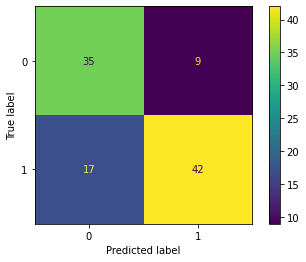

In [ ]:
y_predicted = model_multi_modal.predict([x_test_text, x_test_audio])
y_predicted = np.round(y_predicted).flatten()

cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_predicted))

In [ ]:
y_train

In [ ]:
y_test